# Sandbox

In this notebook, I will be testing the functionality of the new `feemsmix` object. This object will add a sort of meta-functionality by allowing for the creation of K `SpatialGraph` objects: one for each extra long range edge. This object will also contain functions to compare across different graphs:  

1. compute residual correlation matrix across pairs of nodes  

2. output log-likelihood and the improvement in log units as p-values from a $\chi^2$ test  

3. plot the before and after of the graph object on adding the extra edge (alongwith correlation of the overlapping edge weights)  

4. provide two schemes for adding edges -  

    a. exhaustive search  
    
    b. pick max residual and convex hull around it 

5. function to add a given edge and function to not only add edge but also return nll

6. provide two options for number of edges - 

    a. add a set number of edges (caution that more edges reduces interpretibility and may be picking up noise, not signal)

    b. add until there is no longer a significant increase in the log-likelihood (again no biological interpretation for a picked K)

Profile memory usage after all this is complete. First, try this methodology on a known simulated graph, and then move to the AEA data set. 

In [503]:
# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import scipy.sparse as sp
import pandas as pd

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective, FeemsMix
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [571]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 150
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 900
Simulating ~SNP 950


In [ ]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

Below I start experimenting with different procedures to code up the `feemsmix` object...

In [ ]:
graph = list()
graph.append(sp_Graph_def)

In [ ]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(graph[0], lamb_grid, n_folds=None, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])

In [ ]:
#fm = FeemsMix(gen_test, coord, grid, edge_def, n_lre=0, n_folds=10)

In [ ]:
#max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, lamb=lamb_cv, plotFig=True, n_lre=1)

In [ ]:
#max_res_nodes.append([(2,56)])
max_res_nodes.append(tuple(comp_genetic_vs_fitted_distance(sp_Graph_def, lamb=lamb_cv, plotFig=False, n_lre=1)))

In [ ]:
list(sp_Graph_def.edges).append([1,56])

In [483]:
fm = FeemsMix(gen_test, coord, grid, edge_def, n_lre=2, n_folds=2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1

constant-w/variance fit, converged in 120 iterations, train_loss=7030.9129331
lambda=37.9269019, alpha=0.6061827, converged in 21 iterations, train_loss=6896.9556669

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1

NetworkXError: The edge 21-40 is not in the graph

EdgeView([(0, 1), (0, 10), (1, 2), (1, 11), (1, 10), (2, 3), (2, 12), (2, 11), (3, 4), (3, 13), (3, 12), (4, 5), (4, 14), (4, 13), (5, 6), (5, 15), (5, 14), (6, 7), (6, 16), (6, 15), (7, 8), (7, 17), (7, 16), (8, 9), (8, 18), (8, 17), (9, 19), (9, 18), (10, 11), (10, 20), (10, 21), (11, 12), (11, 21), (11, 22), (12, 13), (12, 22), (12, 23), (13, 14), (13, 23), (13, 24), (14, 15), (14, 24), (14, 25), (15, 16), (15, 25), (15, 26), (16, 17), (16, 26), (16, 27), (17, 18), (17, 27), (17, 28), (18, 19), (18, 28), (18, 29), (19, 29), (20, 21), (20, 30), (21, 22), (21, 31), (21, 30), (21, 47), (22, 23), (22, 32), (22, 31), (23, 24), (23, 33), (23, 32), (24, 25), (24, 34), (24, 33), (25, 26), (25, 35), (25, 34), (26, 27), (26, 36), (26, 35), (27, 28), (27, 37), (27, 36), (28, 29), (28, 38), (28, 37), (29, 39), (29, 38), (30, 31), (30, 40), (30, 41), (31, 32), (31, 41), (31, 42), (32, 33), (32, 42), (32, 43), (33, 34), (33, 43), (33, 44), (34, 35), (34, 44), (34, 45), (35, 36), (35, 45), (35, 46

In [ ]:
#fm.graph[1].update(edges=edges_lr, nodes=None)
#[x for x in list(fm.graph[1].edges) if x not in edges_lr]
fm.graph[1].remove_edge(1,56)

In [ ]:
len(fm.graph[1].edges)
fm.graph[1].add_edge(21,47)
len(fm.graph[1].edges)

In [ ]:
# signed incidence_matrix
fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# track nonzero edges upper triangular
fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# adjacency matrix on the edges
fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# vectorization operator on the edges
fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

In [478]:
fm.graph[1].add_edge(*(1,56))

In [479]:
#def _search_hull(n, max_res_nodes):
# TODO: put a progress bar
# spl = dict(nx.all_pairs_shortest_path_length(fm.graph[1],cutoff=4))

# # get closest (within distance 3) AND sampled nodes to create a set of nodes to search over
# n1 = [k for (k, v) in spl[max_res_nodes[0][0]].items() if v>0 and v<4 and k in np.array(np.where(query_node_attributes(fm.graph[1],"n_samples")>0))]
# n2 = [k for (k, v) in spl[max_res_nodes[0][1]].items() if v>0 and v<4 and k in np.array(np.where(query_node_attributes(fm.graph[1],"n_samples")>0))]

# n1.append(max_res_nodes[0][0])
# n2.append(max_res_nodes[0][1])

# lr_hull = (tuple(i) for i in it.product(n1, n2))
# # removing nodes that are already connected in the default graph 
# final_lr_hull = [x for x in list(lr_hull) if x not in list(fm.graph[1].edges)]

# df_hull = pd.DataFrame(index = np.arange(len(final_lr_hull)), columns = ['nodes', 'nll'])

# df_hull['nodes'] = final_lr_hull
# obj = Objective(fm.graph[1])
# obj._solve_lap_sys()
# obj._comp_mat_block_inv()
# obj._comp_inv_cov()
# df_hull.iloc[len(df_hull)-1, 1] = obj.neg_log_lik()
for idx in np.arange(0,len(df_hull)-1)[::-1]:
    df_hull.iloc[idx, 1] = _add_edge_get_nll(1, df_hull.iloc[idx+1, 0], df_hull.iloc[idx, 0], 37.92)
    
# # print nodes connected by THE edge to give lowest negative log likelihood
# return(df_hull.loc[df_hull['nll'].astype(float).idxmin(),:])

ValueError: row, column, and data array must all be the same length

,nodes,nll
0,"(0, 46)",NaN
1,"(0, 47)",NaN
2,"(0, 55)",NaN
3,"(0, 57)",NaN
4,"(0, 35)",NaN
...,...,...
467,"(1, 31)",NaN
468,"(1, 30)",NaN
469,"(1, 53)",NaN
470,"(1, 59)",NaN


In [469]:
def _add_edge_get_nll(n, mrn, new_mrn, lamb):
    fm.graph[n].remove_edge(*mrn)
    fm.graph[n].add_edge(*new_mrn)
    
    fm.graph[n].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()
    fm.graph[n].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[n]), k=1)
    fm.graph[n].nnz_idx = fm.graph[n].adj_base.nonzero()
    fm.graph[n].Delta = fm.graph[n]._create_incidence_matrix()
    fm.graph[n].diag_oper = fm.graph[n]._create_vect_matrix()
    fm.graph[n].w = np.ones(fm.graph[n].size())
    fm.graph[n].comp_grad_w()

    fm.graph[n].fit(lamb = float(lamb), verbose=False)
    obj = Objective(fm.graph[n])
    obj._solve_lap_sys()
    obj._comp_mat_block_inv()
    obj._comp_inv_cov()
    return obj.neg_log_lik()

In [467]:
df_hull

,nodes,nll
0,"(0, 46)",NaN
1,"(0, 47)",NaN
2,"(0, 55)",NaN
3,"(0, 57)",NaN
4,"(0, 35)",NaN
...,...,...
467,"(1, 31)",NaN
468,"(1, 30)",NaN
469,"(1, 53)",NaN
470,"(1, 59)",NaN


In [ ]:
max_res_nodes[0]==df_hull.loc[10,:]['nodes']

In [ ]:
temp_edges[3]

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, fm.graph[1], edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

fm.graph[1].remove_edge(21,47)
fm.graph[1].add_edge(1,56)

In [ ]:
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, fm.graph[1], edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

# signed incidence_matrix
fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# track nonzero edges upper triangular
fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# adjacency matrix on the edges
fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# vectorization operator on the edges
fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

#fm.graph[1].fit(lamb=10.0)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, fm.graph[1], edge_width=2.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)

# fm.graph[1].remove_edge(1,56)
# fm.graph[1].add_edge(21,47)

# fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# # track nonzero edges upper triangular
# fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
# fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# # adjacency matrix on the edges
# fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# # vectorization operator on the edges
# fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

# fm.graph[1].fit(lamb=10.0)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, fm.graph[1], edge_width=2.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)

In [ ]:
print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(2.*(fm.nll[2] - fm.nll[0]),chi2.sf(2.*(fm.nll[0] - fm.nll[2]),2)))

In [ ]:
plot_default_vs_long_range(fm.graph[0], fm.graph[2], [(21,47)], lamb=np.array((37.92,37.92)))

In [ ]:
fig = plt.figure(dpi=300)
projection=ccrs.EquidistantConic(central_longitude=np.median(coord[:,0]), central_latitude=np.median(coord[:,1]))
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, fm.graph[2], projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

## Reworking the objective function

Below, I will work on adding an extra penalty term to the `Objective` function for penalizing weights of long range edges to be zero (lasso penalty). This will require passing in the extra edges to the `SpatialGraph` object and propagating that downstream. 

I've changed the source code in `spatial_graph.py` and `objective.py`, and will test functionality below here. 

1. One long range edge with large migration rate (~4x of barrier)

*If the estimated long range edge is in a barrier, then the penalization scheme pushes it down to zero (as expected). But if the estimated long range edge is in a corridor, then the penalization scheme overestimates the value (pushes it beyond simulated, but performance increase of about 7 points). Overall correlation is very similar for the other sets of weights in the graph.* 

In [711]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [712]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, plotFig=False, lamb=14.4)
sp_Graph_def.fit(lamb=14.4)

constant-w/variance fit, converged in 127 iterations, train_loss=8880.5915961
lambda=14.4000000, alpha=0.6082233, converged in 14 iterations, train_loss=8555.4046943


In [713]:
edges_lr = deepcopy(edge_def.tolist())
edges_lr.append([22,48])

In [714]:
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47)])
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=10, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv)

sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph2.fit(lamb=lamb_cv2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1constant-w/variance fit, converged in 129 iterations, train_loss=8706.7555845
lambda=2.0691381, alpha=0.6525994, converged in 7 iterations, train_loss=8006.3327116

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha

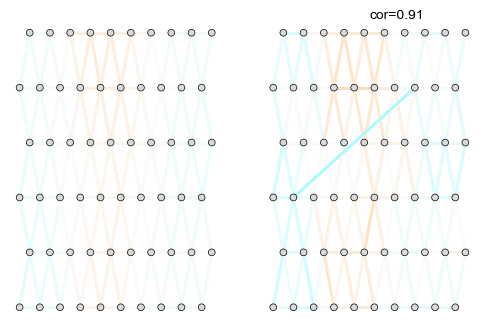

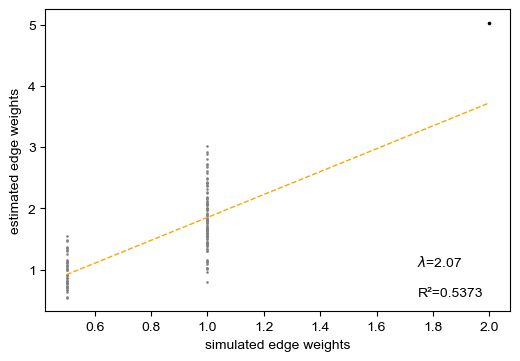

In [715]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47)], lamb=np.array((10.0,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv)

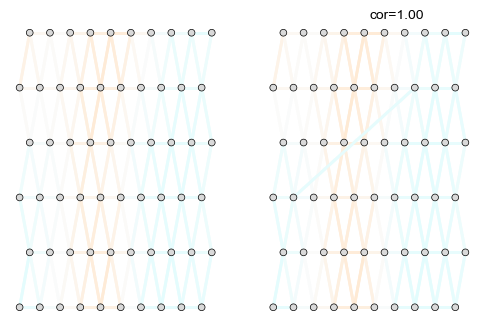

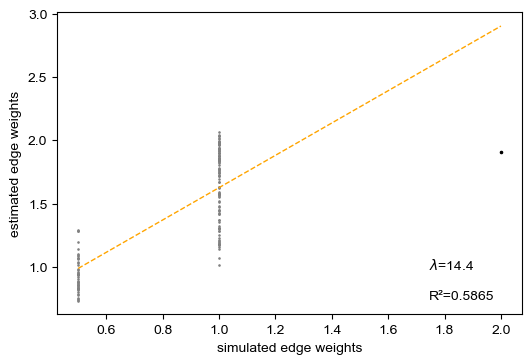

In [640]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47)], lamb=np.array((10.0,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv2)

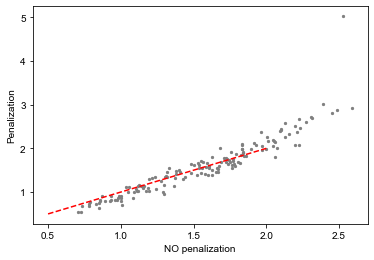

In [716]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()

2. One long range edge with small migration rate (~1x of barrier)

*When estimating with the `max_res_nodes edges`, the model works similarly in both cases. However, when estimating with the correct simulated edge, the non-penalized fit is better by about 13 points and correlation with simulated edge weights is better by about 18 points. However, in 3/4 cases tested so far the weight for the long range edge is closer to the simulated weight when using the penalized scheme.*

In [717]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [718]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
sp_Graph_def.fit(lamb=14.4)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, plotFig=False, lamb=14.4)

constant-w/variance fit, converged in 140 iterations, train_loss=8945.5042251
lambda=14.4000000, alpha=0.6231032, converged in 15 iterations, train_loss=8668.8232327


[(21, 47)]

In [719]:
edges_lr = deepcopy(edge_def.tolist())
edges_lr.append([22,48])

sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47)])
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=10, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv)

sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph2.fit(lamb=lamb_cv2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1constant-w/variance fit, converged in 132 iterations, train_loss=8895.8960872
lambda=100.0000000, alpha=0.6729359, converged in 13 iterations, train_loss=8946.3365584

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 al

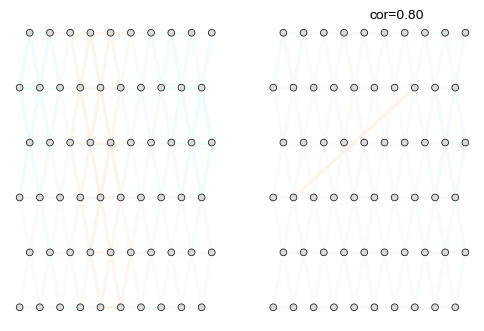

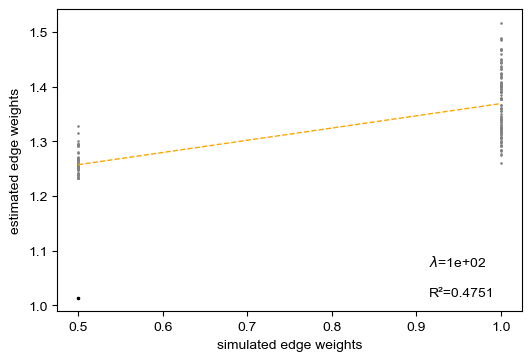

In [675]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47)], lamb=np.array((14.4,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv)

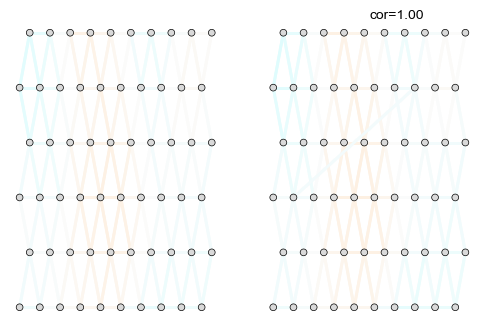

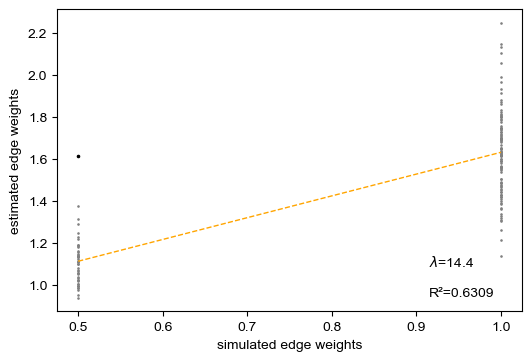

In [720]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47)], lamb=np.array((14.4,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv2)

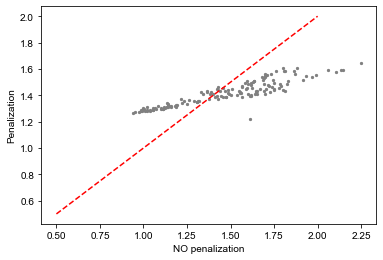

In [721]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()

3. Multiple disjoint edges with varying weights

*When using the `max_res_nodes` edges, there is a 4.5 points performance improvement when using a no-penalization scheme. On average, the no-penalization scheme performs better when estimating the long range edge weights. The penalization scheme pushes most edges to zero, but keeps one at a very high value (as expected -- simulated case is worst scenario). However, when using the correct edges (as simulated), the performance of the penalization scheme is much better (by about 7 points) and the estimated edge weights are closer to the simulated (penalized edge weights vs non-penalized edge weights still follow a wave-like pattern).*  

In [678]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47), (13,54), (8,31)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0,2.0,2.0])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [694]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
sp_Graph_def.fit(lamb=14.4)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=15, plotFig=False, lamb=14.4)

constant-w/variance fit, converged in 124 iterations, train_loss=7031.0193748
lambda=14.4000000, alpha=0.6026800, converged in 15 iterations, train_loss=6750.5795660


[(8, 31),
 (18, 31),
 (53, 59),
 (19, 31),
 (9, 31),
 (6, 59),
 (11, 18),
 (3, 34),
 (34, 53),
 (26, 59),
 (3, 59),
 (34, 59),
 (28, 31),
 (4, 34),
 (11, 19)]

In [701]:
edges_lr = deepcopy(edge_def.tolist())
edges_lr.append([22,48])
edges_lr.append([14,55])
edges_lr.append([9,32])

sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47), (13,54), (8,31)])
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=10, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv)

sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph2.fit(lamb=lamb_cv2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1constant-w/variance fit, converged in 125 iterations, train_loss=6647.5969504
lambda=100.0000000, alpha=0.6997096, converged in 3 iterations, train_loss=7045.3777276

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alp

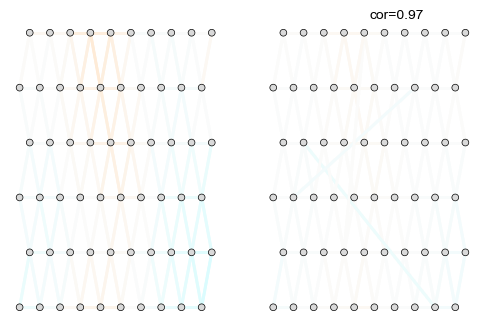

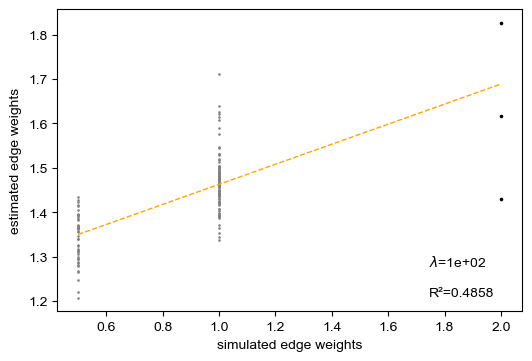

In [702]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=np.array((14.4,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=lrn, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=lamb_cv)

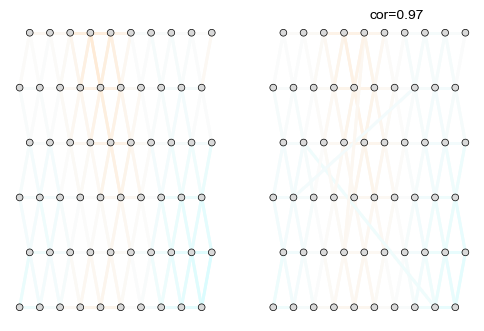

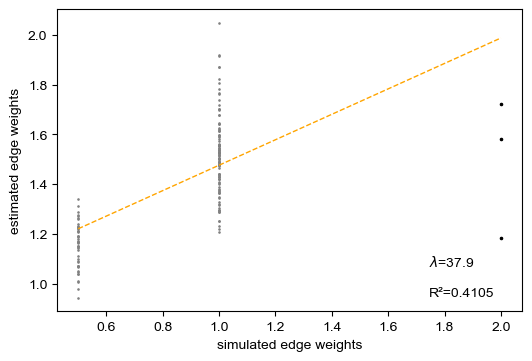

In [703]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=np.array((14.4,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=lrn, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=lamb_cv2)

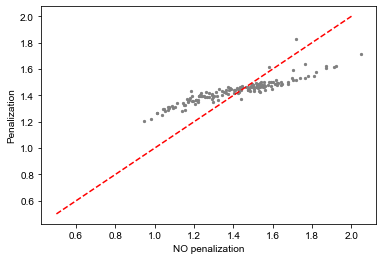

In [704]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()